# Instalacion e importacion de librerias

In [1]:
! pip install opendatasets --user
! pip install folium --user
! pip install statsmodels --user

In [2]:
import opendatasets as od
import pandas as pd
import requests
import folium
from folium import Marker
from folium.plugins import HeatMap
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
dataset_url='https://www.kaggle.com/datasets/juanmartnrodrguez/argentina-dataset-propiedades'
od.download(dataset_url)

Skipping, found downloaded files in ".\argentina-dataset-propiedades" (use force=True to force download)


# Introduccion


**Contexto Empresarial:** Eres un cientifico de datos de una organizacion. Dicha organizacion se dedica al desarrollo inmobiliario a lo largo de Argentina. El modelo de negocio es comprar terrenos, contratar a una constructora, desarrollar y vender o alquilar propiedades. En los ultimos años la empresa no ha tenido exito en las ventas y en los lugares a desarrollar. La gerencia plantea la hipotesis de que localidad o provincia tiene mayor rentabilidad para desarrollar negocios inmobililarios.

**Problema Empresarial:** El equipo de ventas junto con la gerencia se acerca hacia nosotros para responder la siguiente pregunta: ¿Cual es la mejor zona para desarrollar propiedades que se puedan vender rapido?, si es asi, ¿Que tipo de propiedades se suelen vender mas rapido?

**Contexto Analitico:** El departamento de ventas nos ha provisto una base de datos con todas las ventas de propiedades en Argentina que contiene atributos como fecha de inicio de publicacion de la propiedad, fecha de fin de la publicacion de la propiedad, precio de venta,cantidad de ambientes, baños, superficie total y cubierta, y mas. Veremos que con una regresion lineal podemos cuantificar la correlacion entre la variable dependiente (tipo de propiedad) y las variables dependientes (Precio, tiempo en el mercado, cantidad de baños, habitaciones,etc.)

El caso esta estructurado de la siguiente manera: (1) realizaremos un analisis de datos explotaratorio para investigar visualmente rangos de precio para distintos tipos de propiedades, cantidad de propiedades vendidas por provincias y diferencias entre localidades. (2) utilizar los conocimientos sobre regresion lineal para ajustar el modelo y finalmente (3) abordar el tema principal de la hipotesis.

# Exploracion de datos

In [5]:
df = pd.read_csv('./argentina-dataset-propiedades/ar_properties.csv')
df.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,wdQ5hWhv8P14T7Sh9g4QCg==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-32.716652,-68.642692,Argentina,Mendoza,NaN,...,NaN,350.0,350.0,NaN,NaN,NaN,Excelentes Lotes Sobre Ruta 34,Corredor Responsable: VICTOR E. MONTIVERO - C....,Lote,Venta
1,nnMBYZ4RMRY+vm753EtA+g==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-24.797723,-65.467514,Argentina,Salta,NaN,...,NaN,1541.0,1541.0,NaN,NaN,Mensual,TERRENO + VENTA + JARDINES DE SAN LORENZO +150...,Corredor Responsable: Pablo Castañeda - C.U.C....,Lote,Venta
2,+dnVA1K6JxzL1zAjOEQ1pA==,Propiedad,2020-12-25,2020-12-29,2020-12-25,-34.919373,-58.020591,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote en Venta de 1000 m2 en La Plata,Corredor Responsable: Rico Sebastián - Martill...,Lote,Venta
3,dLHXKN5/sRZpm9Yk0yI2nA==,Propiedad,2020-12-25,2020-12-29,2020-12-25,-34.919455,-58.024807,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,NaN,1000.0,1000.0,NaN,NaN,Mensual,Lote en Venta de 1000 m2 en La Plata,Corredor Responsable: Rico Sebastián - Martill...,Lote,Venta
4,wtw/k887EPipd37UYHKb1Q==,Propiedad,2020-12-25,9999-12-31,2020-12-25,-34.364924,-58.783143,Argentina,Bs.As. G.B.A. Zona Norte,Escobar,...,NaN,18164.0,18164.0,NaN,NaN,Mensual,PANAMERICANA 47300,Nave principal 66 x 90 m: 6005 m2 cubiertos...,Otro,Venta


In [6]:
df.shape

(1000000, 25)

In [7]:
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type'],
      dtype='object')

Las variables disponibles son:

- type - Tipo de aviso (Propiedad, Desarrollo/Proyecto).
- id - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas: de alta y de baja.
- start_date - Fecha de alta del aviso.
- end_date - Fecha de baja del aviso.
- created_on - Fecha de alta de la primera versión del aviso.
- place - Campos referidos a la ubicación de la propiedad o del desarrollo.
    - lat - Latitud.
    - lon - Longitud.
    - l1 - Nivel administrativo 1: país.
    - l2 - Nivel administrativo 2: usualmente provincia.
    - l3 - Nivel administrativo 3: usualmente ciudad.
    - l4 - Nivel administrativo 4: usualmente barrio.
- property - Campos relativos a la propiedad (vacío si el aviso es de un desarrollo/proyecto).
    - operation - Tipo de operación (Venta, Alquiler).
    - type - Tipo de propiedad (Casa, Departamento, PH).
    - rooms - Cantidad de ambientes (útil en Argentina).
    - bedrooms - Cantidad de dormitorios (útil en el resto de los países).
    - bathrooms - Cantidad de baños.
    - surface_total - Superficie total en m².
    - surface_covered - Superficie cubierta en m².
    - price - Precio publicado en el anuncio.
    - currency - Moneda del precio publicado.
    - price_period - Periodo del precio (Diario, Semanal, Mensual)
    - title - Título del anuncio.
    - description - Descripción del anuncio.
- name - Nombre del desarrollo.
- description - Descripción del anuncio.

Primero filtrar por las caracteristicas que precisamos:

- Que sea de Argentina
- Que la propiedad este terminada y vendida
- Que sea una propiedad; que no sea Desarrollo o proyecto
- Que en el precio no este en nulo y que esté en dolares

In [8]:
df = df[(df['l1'] == 'Argentina') & (df['currency'] == 'USD') & (df['operation_type'] == 'Venta')]


Cambio de formato en columnas de fecha, reemplazo de datos con fecha indefinida (para no exceder el Timestamp) y creación de una nueva columna informando sin finalizó, o no, el anuncio.

In [9]:
from datetime import date
from datetime import datetime

In [10]:
today = date.today()
now = datetime.now()

In [11]:
df.columns
pd.Timestamp.max

Timestamp('2262-04-11 23:47:16.854775807')

In [12]:
df = df.replace({"9999-12-31" : "2250-12-31"})

In [13]:
df['finalizo_anuncio'] = np.where(df['end_date'] == '2250-12-31', 'No', 'Si')

In [14]:
df['start_date'] = pd.to_datetime(df['start_date'], format = '%Y-%m-%d')
df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d')
df = df[df['finalizo_anuncio'] == 'Si']


Una vez filtrados los datos ya cumplimos las especificaciones principales, que se haya vendido, que sea de Argentina y que el precio sea en USD.

Ahora hay que pasar a limpiar la data de valores nulos y poner los tipos de datos como corresponden

In [15]:
df.columns

Index(['id', 'ad_type', 'start_date', 'end_date', 'created_on', 'lat', 'lon',
       'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'currency', 'price_period',
       'title', 'description', 'property_type', 'operation_type',
       'finalizo_anuncio'],
      dtype='object')

In [16]:
#Sacar NA
df = df.dropna(subset=['price','surface_total','surface_covered','price_period','bathrooms','bedrooms','rooms'])
df.head(5)

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,finalizo_anuncio
131,L2WYRjQu5PA9QzlodPmAXg==,Propiedad,2020-12-25,2021-01-13,2020-12-25,-34.918987,-57.939761,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,43.0,41.0,45000.0,USD,Mensual,Venta depto. 1 dormitorio - Av. 60 esq. 5 - La...,"Piso alto, excelente vista y luminosidad. Livi...",Departamento,Venta,Si
371,wYQvnyjYy7Z2E0XNkLneGA==,Propiedad,2020-12-26,2021-03-08,2020-12-26,-34.562809,-58.476758,Argentina,Capital Federal,Congreso,...,49.0,46.0,74000.0,USD,Mensual,¡¡Excelente 2 ambientes!!,"Luminoso dos ambientes!, ubicado a una cuadra ...",Departamento,Venta,Si
376,hxdT2Fv5cifKndBxN/nsiQ==,Propiedad,2020-12-26,2021-01-05,2020-12-26,-34.918933,-57.930270,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,...,64.0,56.0,85000.0,USD,Mensual,Departamento - La Plata,Departamento 1 dormitorio 64 mts cubiertos apr...,Departamento,Venta,Si
379,5WOhu6n1dSQfgnQTy2gZCA==,Propiedad,2020-12-26,2021-01-13,2020-12-26,-34.627708,-58.452229,Argentina,Capital Federal,Caballito,...,31.0,26.0,53000.0,USD,Mensual,Alberdi 1600 - 2 amb - 3er piso por escalera,Monoambiente dividido con balcon al contrafren...,Departamento,Venta,Si
437,mqAJeGuIv1sSU5YwDB9BJQ==,Propiedad,2020-12-26,2021-03-05,2020-12-26,-34.402644,-58.654462,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,...,120.0,83.0,269000.0,USD,Mensual,Inmejorable 3 amb al agua en Portezuelo con ba...,GVL Inmejorable departamento con vista al agua...,Departamento,Venta,Si


In [17]:
#Cambiar tipos de datos

#'price','surface_total','surface_covered','bathrooms','bedrooms','rooms'

df['bathrooms'] = df['bathrooms'].astype(int)
df['price'] = df['price'].astype(float)
df['surface_total'] = df['surface_total'].astype(float)
df['surface_covered'] = df['surface_covered'].astype(float)
df['bedrooms'] = df['bedrooms'].astype(int)
df['rooms'] = df['rooms'].astype(int)
df = df.drop(columns=['ad_type','l5','l6']) #Elimino estas columnas ya que ad_type es el mismo valor para todos los datos y l5 y l6 tiene demasiado valores nulos
df.head()


,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,finalizo_anuncio
131,L2WYRjQu5PA9QzlodPmAXg==,2020-12-25,2021-01-13,2020-12-25,-34.918987,-57.939761,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,43.0,41.0,45000.0,USD,Mensual,Venta depto. 1 dormitorio - Av. 60 esq. 5 - La...,"Piso alto, excelente vista y luminosidad. Livi...",Departamento,Venta,Si
371,wYQvnyjYy7Z2E0XNkLneGA==,2020-12-26,2021-03-08,2020-12-26,-34.562809,-58.476758,Argentina,Capital Federal,Congreso,NaN,...,49.0,46.0,74000.0,USD,Mensual,¡¡Excelente 2 ambientes!!,"Luminoso dos ambientes!, ubicado a una cuadra ...",Departamento,Venta,Si
376,hxdT2Fv5cifKndBxN/nsiQ==,2020-12-26,2021-01-05,2020-12-26,-34.918933,-57.930270,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,La Plata,...,64.0,56.0,85000.0,USD,Mensual,Departamento - La Plata,Departamento 1 dormitorio 64 mts cubiertos apr...,Departamento,Venta,Si
379,5WOhu6n1dSQfgnQTy2gZCA==,2020-12-26,2021-01-13,2020-12-26,-34.627708,-58.452229,Argentina,Capital Federal,Caballito,NaN,...,31.0,26.0,53000.0,USD,Mensual,Alberdi 1600 - 2 amb - 3er piso por escalera,Monoambiente dividido con balcon al contrafren...,Departamento,Venta,Si
437,mqAJeGuIv1sSU5YwDB9BJQ==,2020-12-26,2021-03-05,2020-12-26,-34.402644,-58.654462,Argentina,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,...,120.0,83.0,269000.0,USD,Mensual,Inmejorable 3 amb al agua en Portezuelo con ba...,GVL Inmejorable departamento con vista al agua...,Departamento,Venta,Si


# Algunos graficos descriptivos

## Mapa de densidad sobre propiedades vendidas

In [18]:

map_2 = folium.Map(width = 800, height = 900, location=[-38.371135, -64.368148], titles="cartodbposition", zoom_start=4.5)
df_Ctemp = df[df["lat"].notnull() & df["lon"].notnull()]
HeatMap(data=df_Ctemp[["lat","lon"]], radius=13).add_to(map_2)

map_2

## Algunos graficos

In [34]:
df['Tiempo'] = (df['end_date'] - df['start_date']) / np.timedelta64(1,'D')
df['Tiempo'] = df['Tiempo'].astype(int)

Text(0.5, 0, '')

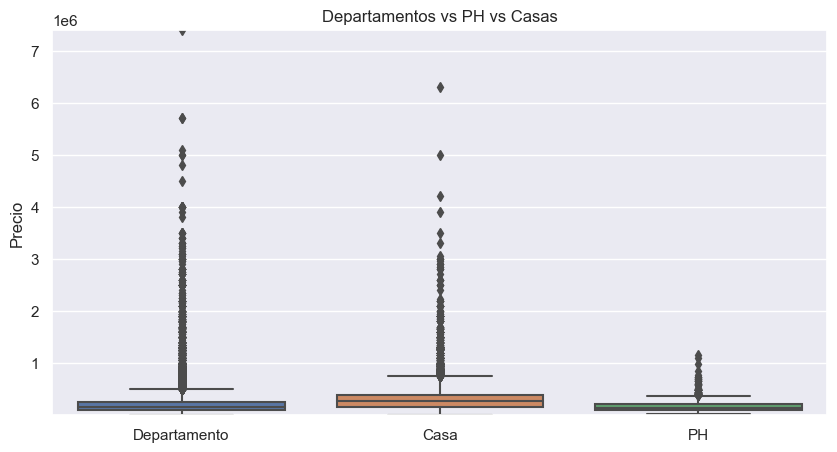

In [20]:
temp_data = df[['property_type','price']]
sns.set(style="darkgrid")  

fig, ax = plt.subplots(figsize=(10,5))
temp_data = temp_data[(temp_data['property_type'] == 'Departamento') | (temp_data['property_type'] == 'Casa') | (temp_data['property_type'] == 'PH')]
g = sns.boxplot(x='property_type',y='price',data=temp_data)
g.set(ylim=(df['price'].min(),df['price'].max()))
plt.title("Departamentos vs PH vs Casas")
plt.ylabel('Precio')
plt.xlabel('')

<AxesSubplot:xlabel='Tiempo en el mercado', ylabel='price'>

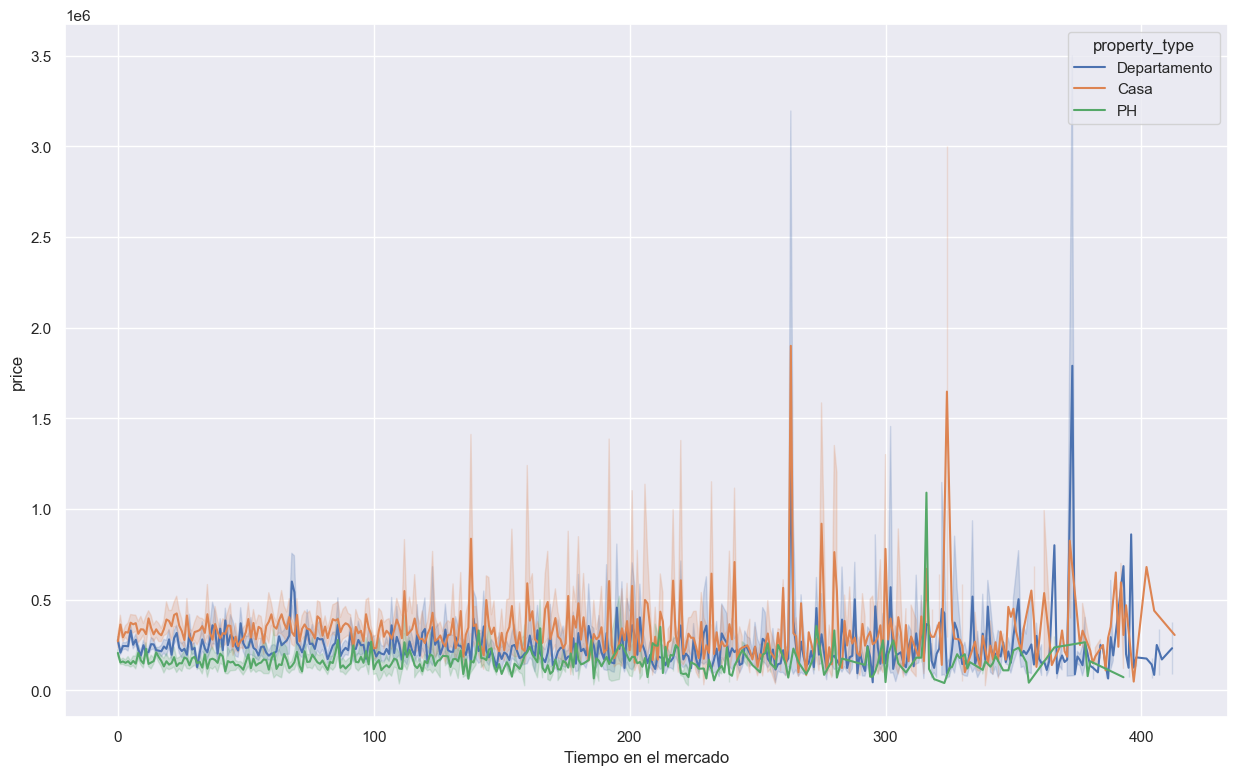

In [21]:
temp_data = df[['Tiempo en el mercado','property_type','price']]
temp_data = temp_data[(temp_data['property_type'] == 'Departamento') | (temp_data['property_type'] == 'Casa') | (temp_data['property_type'] == 'PH')]
sns.set(rc={"figure.figsize":(15,9)})
sns.lineplot(data=temp_data,x='Tiempo en el mercado',y='price',hue='property_type')


Text(0, 0.5, '')

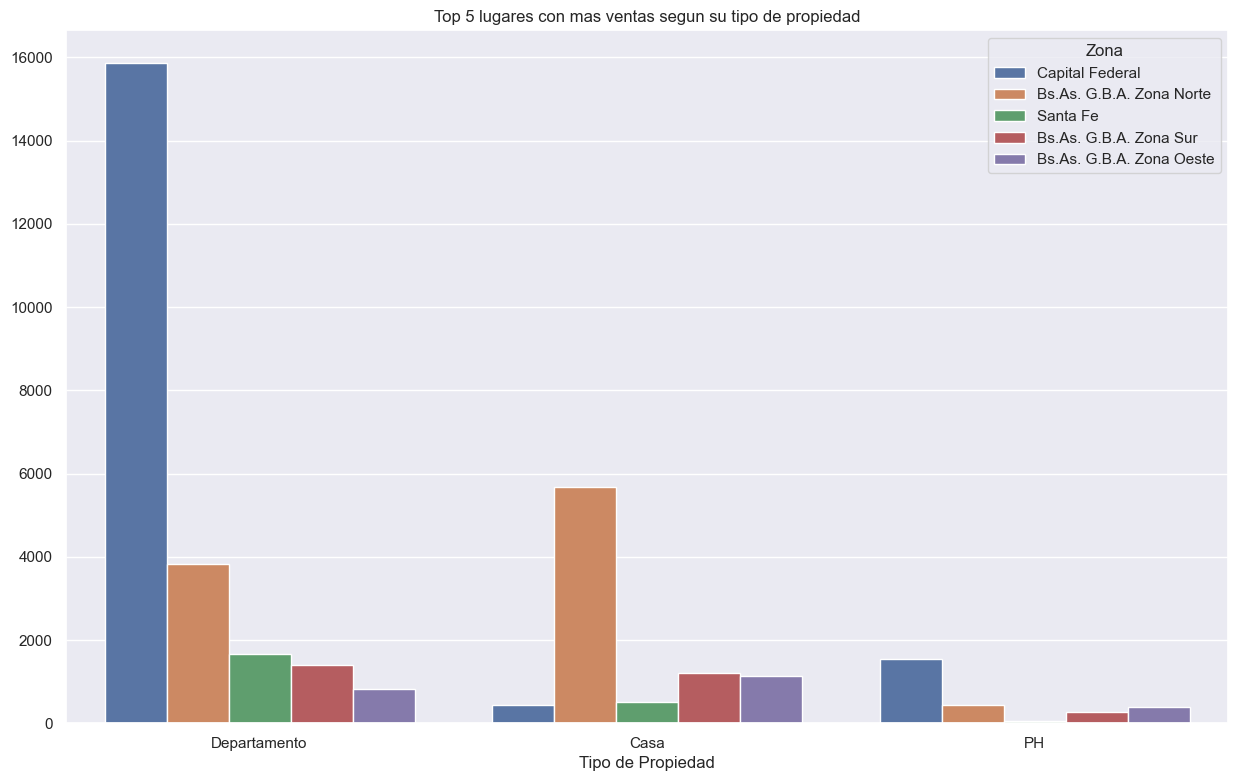

In [33]:
top_5_lugares_con_mas_ventas = df.groupby(["l2","property_type"]).count().reset_index()
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas[['l2','property_type','id']]
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas[(top_5_lugares_con_mas_ventas['l2'] == 'Capital Federal') | (top_5_lugares_con_mas_ventas['l2'] == 'Bs.As. G.B.A. Zona Sur') | (top_5_lugares_con_mas_ventas['l2'] == 'Bs.As. G.B.A. Zona Norte') | (top_5_lugares_con_mas_ventas['l2'] == 'Bs.As. G.B.A. Zona Oeste') | (top_5_lugares_con_mas_ventas['l2'] == 'Santa Fe')]
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas[(top_5_lugares_con_mas_ventas['property_type'] == 'Departamento') | (top_5_lugares_con_mas_ventas['property_type'] == 'Casa') | (top_5_lugares_con_mas_ventas['property_type'] == 'PH')]

top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas.sort_values(by=['id'],ascending=False)
top_5_lugares_con_mas_ventas = top_5_lugares_con_mas_ventas.rename(columns={'l2':'Zona'})

sns.barplot(data=top_5_lugares_con_mas_ventas,x='property_type',y='id',hue='Zona')
plt.title("Top 5 lugares con mas ventas segun su tipo de propiedad")
plt.xlabel('Tipo de Propiedad')
plt.ylabel("")

<AxesSubplot:xlabel='price', ylabel='l3'>

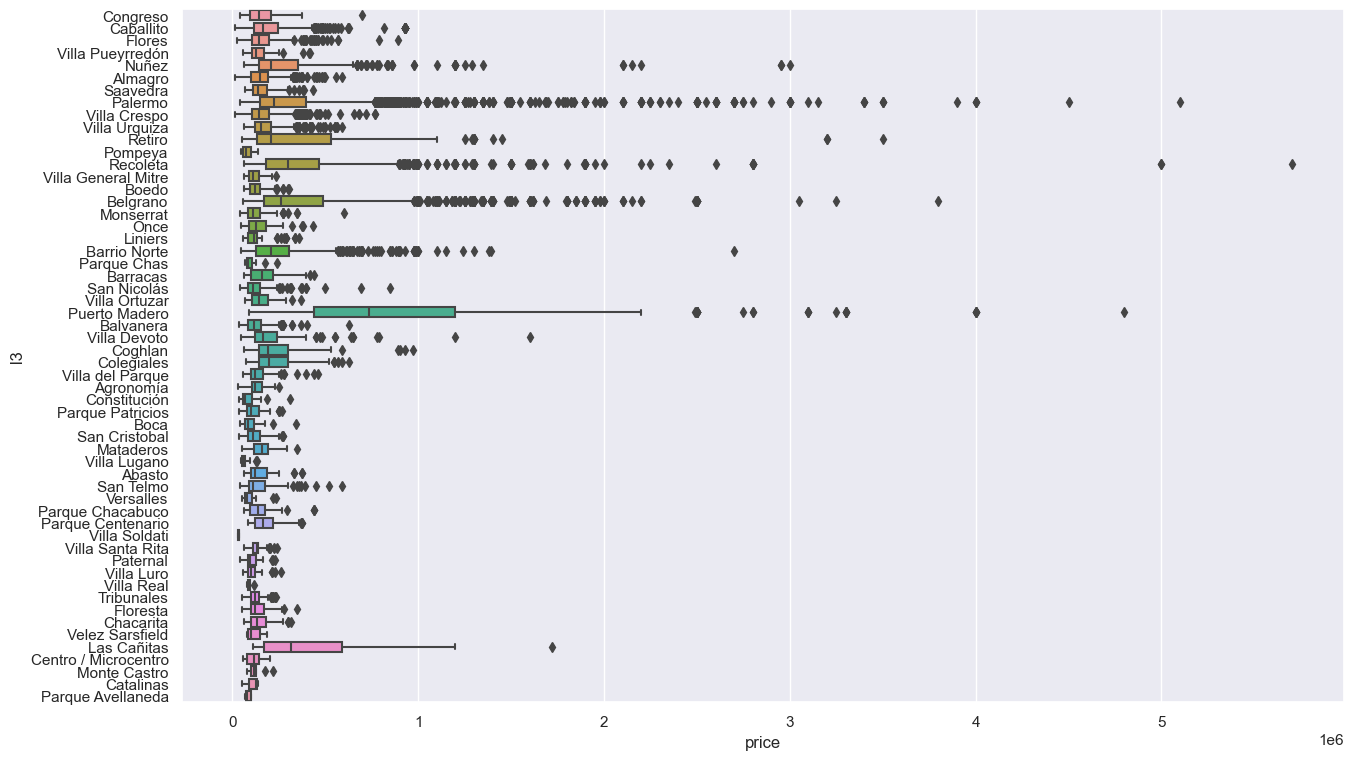

In [74]:
temp = df[(df['property_type'] == 'Departamento') & (df['l2'] == 'Capital Federal')]

sns.boxplot(data=temp,x='price',y='l3',orient='h')

In [42]:
df.columns

Index(['id', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2',
       'l3', 'l4', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type', 'finalizo_anuncio',
       'Tiempo en el mercado', 'Tiempo'],
      dtype='object')

Filtro los datos para averiguar si hay correlaciones entre los tipos de propiedad y las zonas

In [49]:
df = df[(df['l2'] == 'Capital Federal') | (df['l2'] == 'Bs.As. G.B.A. Zona Sur') | (df['l2'] == 'Bs.As. G.B.A. Zona Norte') | (df['l2'] == 'Bs.As. G.B.A. Zona Oeste') | (df['l2'] == 'Santa Fe')]
df = df[(df['property_type'] == 'Departamento') | (df['property_type'] == 'Casa') | (df['property_type'] == 'PH')]

In [75]:
model1 = 'price~l3'
lm1   = sm.ols(formula = model1, data = df).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     66.24
Date:                Tue, 27 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:55:33   Log-Likelihood:            -4.8968e+05
No. Observations:               35038   AIC:                         9.796e+05
Df Residuals:                   34934   BIC:                         9.804e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

La interpretacion que obtenemos sobre este modelo es que no hay absolutamente ninguna correlacion entre tiempo de mercado y el precio de la propiedad. En base a esto nos podemos enfocar en averiguar si hay correlacion entre el tiempo de mercado y el tipo de propiedad.

In [55]:
model1 = 'Tiempo~property_type'
lm1   = sm.ols(formula = model1, data = df).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Tiempo   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     56.08
Date:                Tue, 27 Sep 2022   Prob (F-statistic):           4.84e-25
Time:                        21:39:21   Log-Likelihood:            -1.9897e+05
No. Observations:               35247   AIC:                         3.979e+05
Df Residuals:                   35244   BIC:                         3.980e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Como vemos tampoco hay una correlacion entre el tipo de propiedad y la cantidad de tiempo que tarda en venderse. Lo unico que nos queda es analizar la correlacion entre el tiempo de mercado y la zona

In [64]:
model1 = 'Tiempo~l2+l3'
lm1   = sm.ols(formula = model1, data = df).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:                 Tiempo   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     6.827
Date:                Tue, 27 Sep 2022   Prob (F-statistic):           5.31e-89
Time:                        21:44:20   Log-Likelihood:            -1.9747e+05
No. Observations:               35038   AIC:                         3.952e+05
Df Residuals:                   34934   BIC:                         3.960e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

No parece haber correlacion entre ninguna de las variables, es un poco extraño pero suele pasar, lo unico que nos queda es analizar datos analiticos sin correlacion